!pip install connectivipy

!pip install pyEDFlib

!pip install networkx

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
#import matplotlib.pyplot as plt
import random

In [2]:
import numpy as np
import pyedflib
import pandas as pd
import connectivipy as cp

In [3]:
file_name= 'S038R01.edf'
file_name2= 'S038R02.edf'

In [4]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    
    n = f.signals_in_file
    #signal_labels = f.getSignalLabels()
    signal_labels = [name.replace(".","") for name in f.getSignalLabels()]
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [5]:
labels, data = read_data_file(file_name)
labels2, data2 = read_data_file(file_name2)

1.1 (mandatory) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

https://connectivipy.readthedocs.io/en/latest/tutorial.html

In [6]:
len(labels)

64

In [7]:
def estimation_1(data, nrepp):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf_values = dt.conn('dtf')
    dtf_significance = dt.significance(Nrep=nrepp, alpha=0.05)
    return dtf_significance

In [8]:
def estimation_2(data, freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf = cp.conn.dtf_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return dtf

In [9]:
def estimation_3(data,freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    pdc = cp.conn.pdc_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return pdc

In [10]:
def find_T_est_1(significance,density): # i think our graph will be directed, 
    #but in case if it is undirected the we need to change formula
    total_num = significance.shape[0]*(significance.shape[1])
    k = significance.shape[0]
    n = int( density*total_num+k)
    T = sorted(significance.flatten())[-n]
    return T

In [11]:
def build_adj(est, T):
    adj = 1*(est>T)
    return adj

In [12]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [13]:
def build_graph(adj,labels):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    Edges = [(labels[idx_i[i]],labels[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    our_graph=nx.DiGraph()
    our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


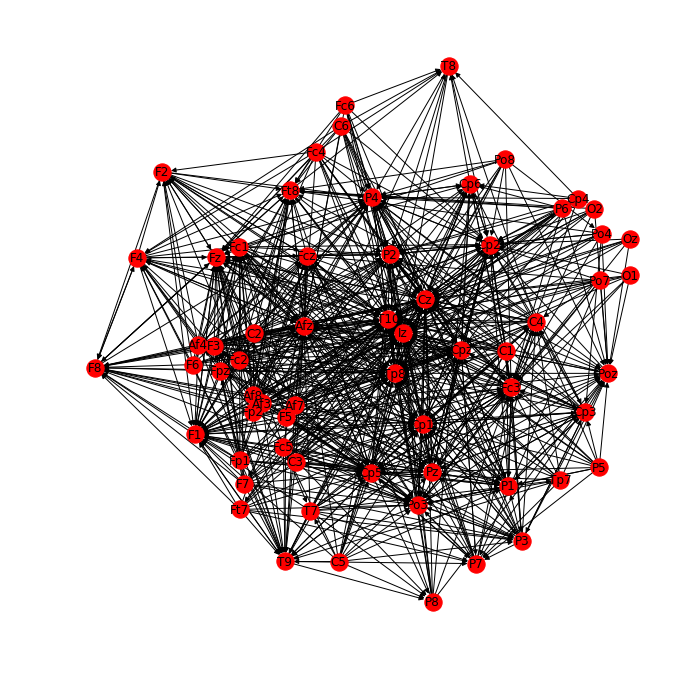

In [14]:
dtf= estimation_2(data,9)
T= find_T_est_1(dtf,0.2)
adjj= build_adj(dtf, T)
gg= build_graph(adjj,labels)

In [15]:
len(gg.edges)/(64*63)

0.20287698412698413

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


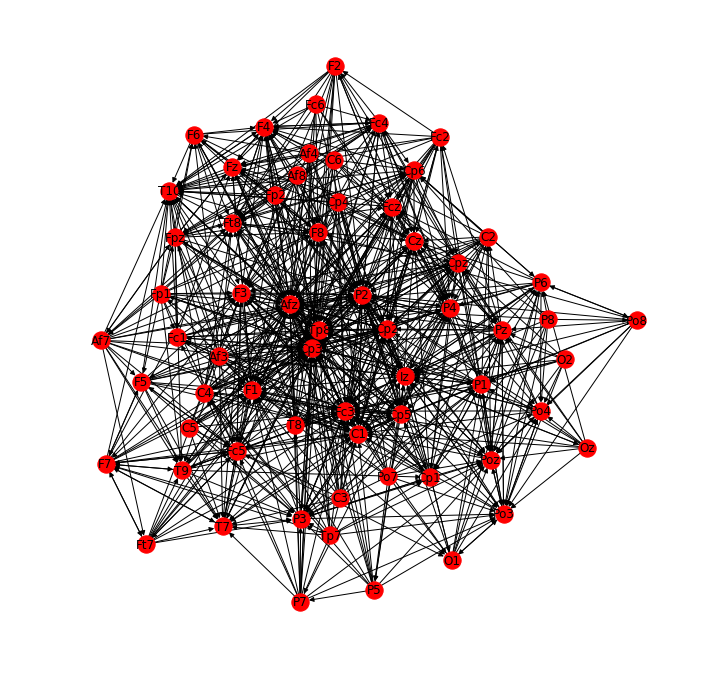

In [16]:
dtf2= estimation_2(data2,9)
T= find_T_est_1(dtf2,0.2)
adjj2= build_adj(dtf2, T)
gg2= build_graph(adjj2,labels2)

In [17]:
len(gg2.edges)/(64*63)

0.20287698412698413

# 1.2
(class ‘A’) Perform task 1.1 using both estimators (PDC and DTF).

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


False


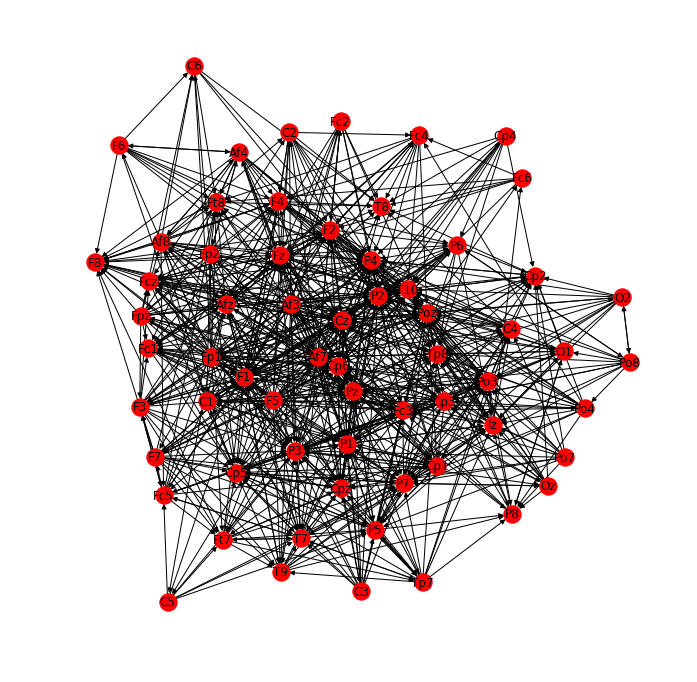

In [18]:
pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.2)
adjj= build_adj(pdc, T)
print(check_symmetric(adjj))
gg3= build_graph(adjj,labels)

In [19]:
len(gg3.edges)/(64*63)

0.20287698412698413

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


False


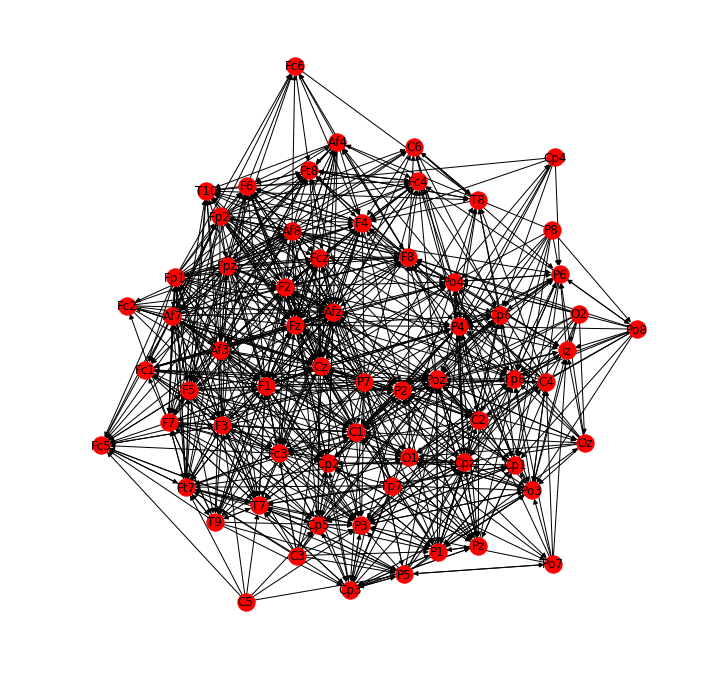

In [20]:
pdc2= estimation_3(data2,9) # second approach

T= find_T_est_1(pdc2,0.2)
adjj3= build_adj(pdc2, T)
print(check_symmetric(adjj3))
gg4= build_graph(adjj3,labels2)

In [21]:
len(gg4.edges)/(64*63)

0.20287698412698413

# 1.4.
(class ‘D’) Considering the subset of 19 channels suggested in Figure 1 and Table 2, estimate
the connectivity using PDC or DTF and apply a statistical validation method (asymptotic
statistics 7 , resampling procedure 8 ,...) to filter out values that are not significantly different
from 0 (PDC(i, j) ≠ 0 with p < 5%)

In [22]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels.index(sub_labels[i]) for i in range(19)]
sub_data = data[idx_labels,]

In [23]:
sign_19= estimation_1(sub_data, 100) # in this procedure is already specified alpha=0.05

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


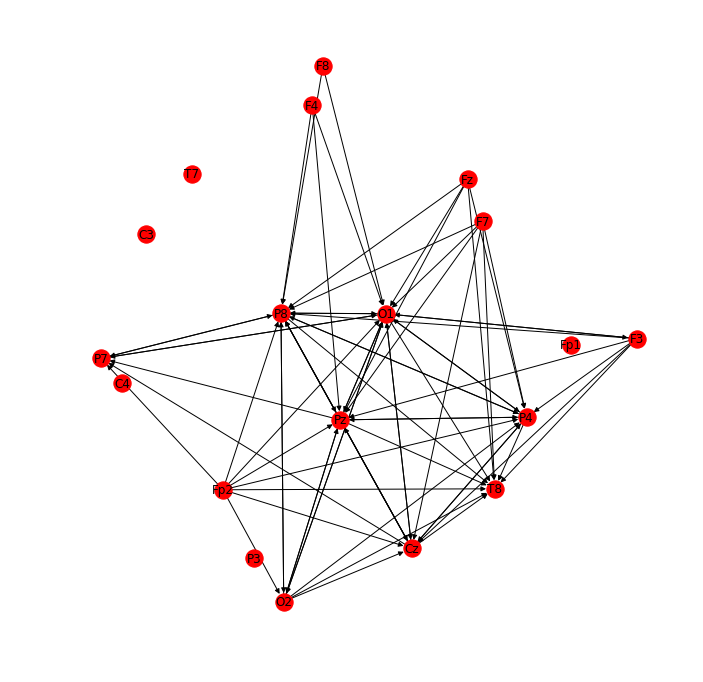

In [24]:
T= find_T_est_1(sign_19,0.2)
adjj19= build_adj(sign_19, T)
gg5= build_graph(adjj19,sub_labels)

In [25]:
len(gg5.edges)/(19*18)

0.20760233918128654

In [26]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels2.index(sub_labels[i]) for i in range(19)]
sub_data2 = data2[idx_labels,]

In [27]:
sign_19_2= estimation_1(sub_data2, 100) # in this procedure is already specified alpha=0.05

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


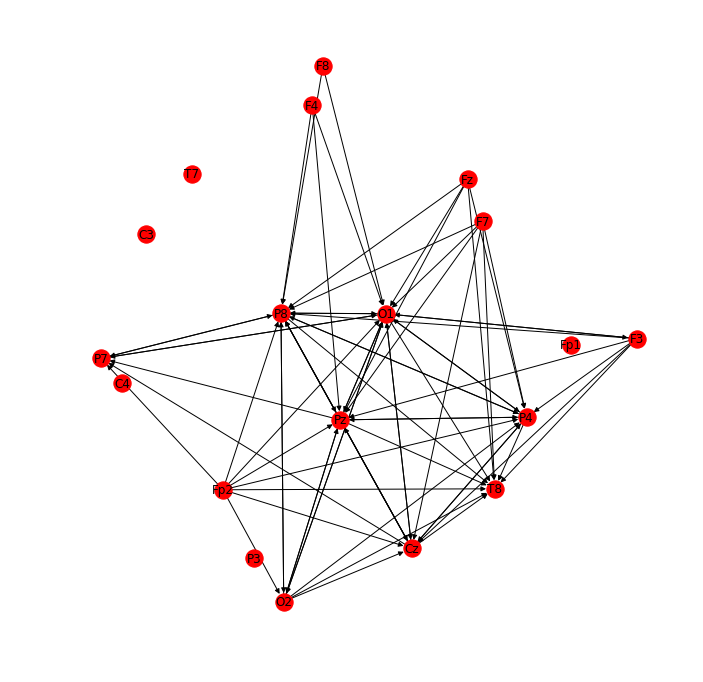

In [28]:
T= find_T_est_1(sign_19,0.2)
adjj19_2= build_adj(sign_19, T)
gg6= build_graph(adjj19_2,sub_labels)

In [29]:
len(gg6.edges)/(19*18)

0.20760233918128654

# 1.5.
(class ‘C’) Make a topographical representation of the networks (see example in Figure 2).
Cartesian coordinates of planar representation of EEG channels are available in Table 3 (see
also
the
file
channel_locations.txt).
(the choice of this task is advised in the case of 19-channel networks and/or density ≤ 5%).

In [30]:
#channel_locations.txt
chanel_locations = pd.read_table('channel_locations.txt', sep=' ', usecols=['label','x','y'])
chanel_locations['label']=chanel_locations['label'].str.replace('.','')

In [31]:
chanel_locations[chanel_locations['label']=='Fc5']['x'].values.item(0)

-0.278155156

In [32]:
def build_graph_1_5(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

False


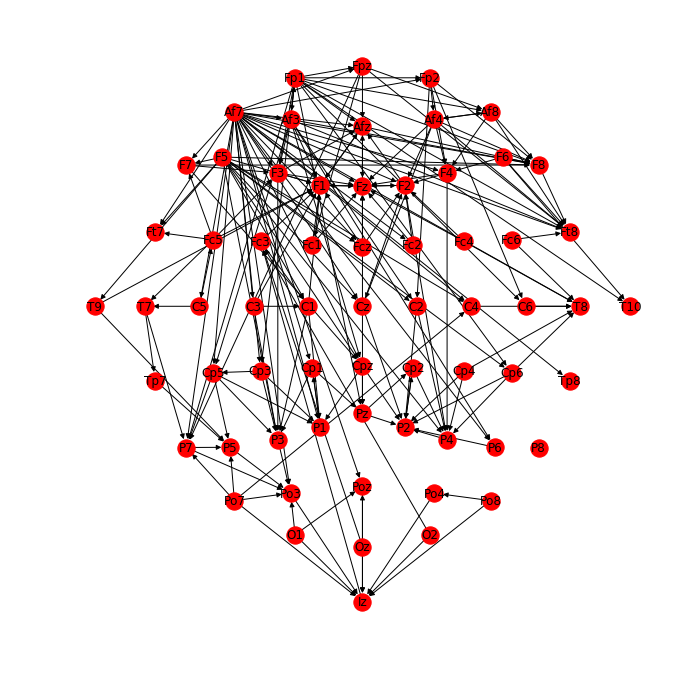

In [33]:
#pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.05)
adjj005= build_adj(pdc, T)
print(check_symmetric(adjj005))
gg7= build_graph_1_5(adjj005,labels,labels,chanel_locations)

In [34]:
len(gg7.edges)/(64*63)

0.050347222222222224

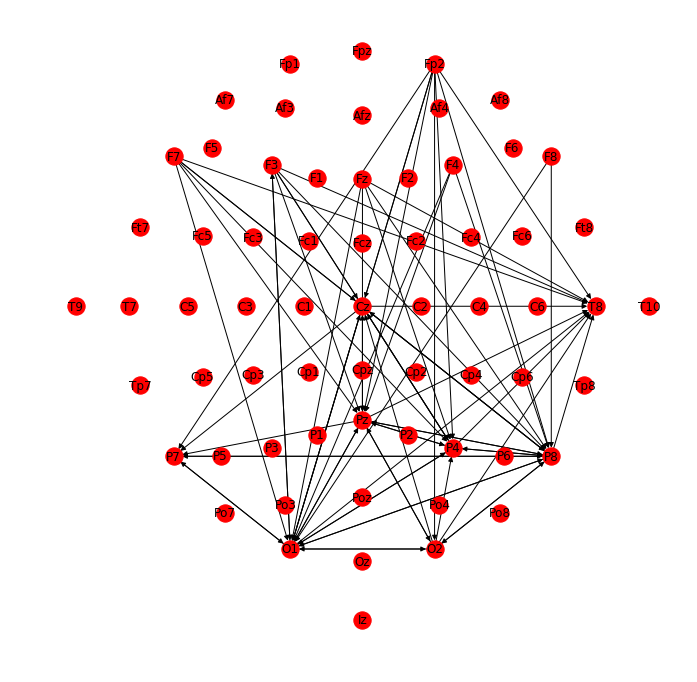

In [35]:
gg8= build_graph_1_5(adjj19,sub_labels,labels,chanel_locations)

In [36]:
len(gg8.edges)/(64*63)

0.017609126984126984

# 2.1
(mandatory) Compute binary global (clustering coefficient, path length) and local (degree,
in/out-degree) graph indices. List the highest 10 channels for local indices.


C_n = e_n/(k_n(k_n-1))
C_n - clustering coeff of node n
e_n - number of edges among neigbors
k_n - number possible edges number

In [37]:
#global clustering coefficient, is avg of CC among all nodes
def avg_CC(graph):
    CC=[]
    all_edg = set()
    for node in graph.nodes:
        #print(node)
        neighbors = (set(graph.successors(node))).union(set(graph.predecessors(node)))
        #print(neighbors)
        e=0
        neighbors.add(node)
        edges = set(graph.in_edges(node))
        edges= edges.union(set(graph.out_edges(node)))
        for ne in neighbors:
            edges= edges.union(set(graph.in_edges(ne)))
            edges = edges.union(set(graph.out_edges(ne)))
            
            #print("edges")
            #print(edges)
        for edg in edges:
            x, y = edg

            if (x in neighbors) and (y in neighbors):
                e=e+1
                    #print(1)
            #all_edg = all_edg.union(edges)
        #print(e)
        k = len(neighbors)*(len(neighbors)-1)
        #print(k)
        CC.append(e/(k))
    return np.sum(CC)/len(CC)

In [38]:
(avg_CC(gg)) 

0.4096549614681534

The **global/average path length** is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. We can calculate the average path length of a directed graph by using this following formula:

*l*<sub>G</sub> = $\frac{1}{n(n-1)}\sum_{i \neq j}d(v_{i}, v_{j})$

where $d(v_{i}, v_{j})$ represents the length of shortest path exists between two vertices and *_n_* the number of vertices in *G*. <br> So, we take sum of all shortest paths between all vertices and divide number of all possible paths.

In [40]:
#global/average path length
def avg_path(graph):
    l=[]
    for node in graph:
        # find all the descendants for each node
        descendants = set(nx.shortest_path_length(graph, node)) - set([node])
        e=0
        for x in descendants:
            # shortest path between two vertices
            s_p = nx.shortest_path_length(graph,source=node,target=x)
            e=e+s_p
        l.append(e)
        e_t = sum(l)
        k = len(graph.nodes())*(len(graph.nodes())-1)
    return (e_t/k)

In [41]:
#the average path length is:
avg_path(gg)

0.8432539682539683

In [42]:
#SHORTEST VERSION
def average_path(graph):
    return(nx.average_shortest_path_length(graph))

In [43]:
print(average_path(gg))

0.8432539682539683


The **degree** of a node *_i_* (*_i_* $\in [1, N], N$ number of nodes) is the total number of connections with other vertices. 
<br> The greater the degree, the more important is the presence of that node for the whole system.

In directed graph, the degree can be split into **in-degree** and **out-degree**: <br>

*In-degree* of node *_i_* is the total amount of links incoming to the vertex *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{in} = \sum_{j = 1, i \neq j}^{N} a_{ji}$, &nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{in}\in [0, N-1]$

*Out-degree* of node *_i_* is the total amount of links outgoing from the vertex *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{out} = \sum_{j = 1, i \neq j}^{N} a_{ij}$, &nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{out}\in [0, N-1]$

*Degree* of node *_i_* is the sum of incoming and outgoing degrees of node *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i} = k_{i}^{in} + k_{i}^{out}$

In [44]:
#in-degree
def in_degree(graph):
    in_d_10 = sorted(graph.in_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(in_d_10)

In [45]:
#highest 10 channels for in-degree 
in_degree(gg) 

[('T10', 60),
 ('Iz', 60),
 ('Tp8', 56),
 ('Cz', 47),
 ('P2', 38),
 ('Cp2', 33),
 ('Cp1', 32),
 ('Fz', 30),
 ('Fc3', 29),
 ('Afz', 29)]

In [46]:
#out-degree
def out_degree(graph):
    out_d_10 = sorted(graph.out_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(out_d_10)

In [47]:
#highest 10 channels for out-degree
out_degree(gg)

[('Cp5', 21),
 ('Afz', 20),
 ('Cp3', 19),
 ('Af7', 19),
 ('Fc5', 18),
 ('Fc3', 18),
 ('Fp1', 18),
 ('Fp2', 18),
 ('Af3', 18),
 ('F5', 18)]

In [48]:
#degree
def degree(graph):
    d_10 = sorted(graph.degree(), key = lambda x: x[1], reverse = True)[:10]
    return(d_10)

In [49]:
#highest 10 channels for degree
degree(gg)

[('Iz', 68),
 ('Cz', 61),
 ('Tp8', 61),
 ('T10', 60),
 ('Cp5', 49),
 ('Cp1', 49),
 ('Afz', 49),
 ('Fc3', 47),
 ('P2', 46),
 ('Cp2', 44)]

# 2.3

(class 'B') Compare the global indices extracted from PDC and DTF connectivity estimations.

In [50]:
#global clustering coefficient with PDC
avg_CC(gg3)

0.326237732581205

In [51]:
#average path length with PDC
avg_path(gg3)

2.6731150793650795

# 2.5

(class 'B') Make a topographical representation of local indices.

In [52]:
def build_graph_degree(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    color_map = []
    for i in range(len(labels)):
        if i in [labels.index(nodes[i]) for i in range(10)]:
            color_map.append('blue')
        else:
            color_map.append('red')    
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,node_color = color_map,with_labels=True)
    plt.draw()
    plt.show()
    return our_graph

In [53]:
indegree_channels = [item[0] for item in list(in_degree(gg))]
idx_indegree = [labels.index(indegree_channels[i]) for i in range(10)]
sub_indegree = data[idx_indegree,]

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


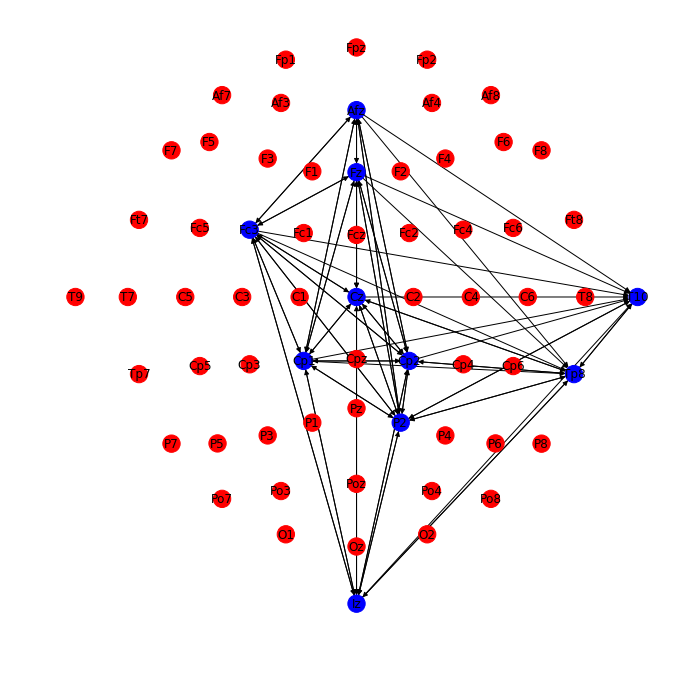

In [54]:
indegree_est = estimation_1(sub_indegree, 100)
T = find_T_est_1(indegree_est,0.80)
adjj_indegree= build_adj(indegree_est, T)
gg_local_indegree = build_graph_degree(adjj_indegree,indegree_channels,labels,chanel_locations)

In [55]:
outdegree_channels = [item[0] for item in list(out_degree(gg))]
idx_outdegree = [labels.index(outdegree_channels[i]) for i in range(10)]
sub_outdegree = data[idx_outdegree,]

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


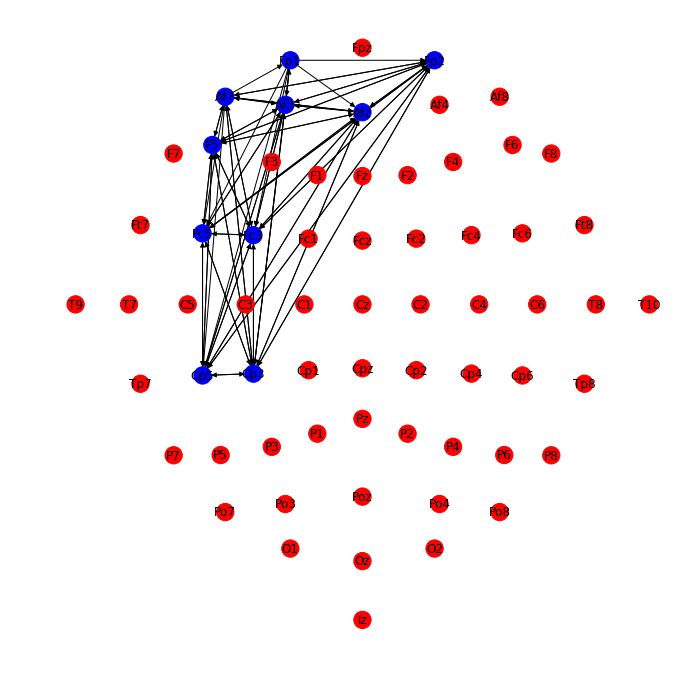

In [56]:
outdegree_est = estimation_1(sub_outdegree, 100)
T = find_T_est_1(outdegree_est,0.80)
adjj_outdegree= build_adj(outdegree_est, T)
gg_local_outdegree = build_graph_degree(adjj_outdegree,outdegree_channels,labels,chanel_locations)

In [57]:
degree_channels = [item[0] for item in list(degree(gg))]
idx_degree = [labels.index(degree_channels[i]) for i in range(10)]
sub_degree = data[idx_degree,]

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


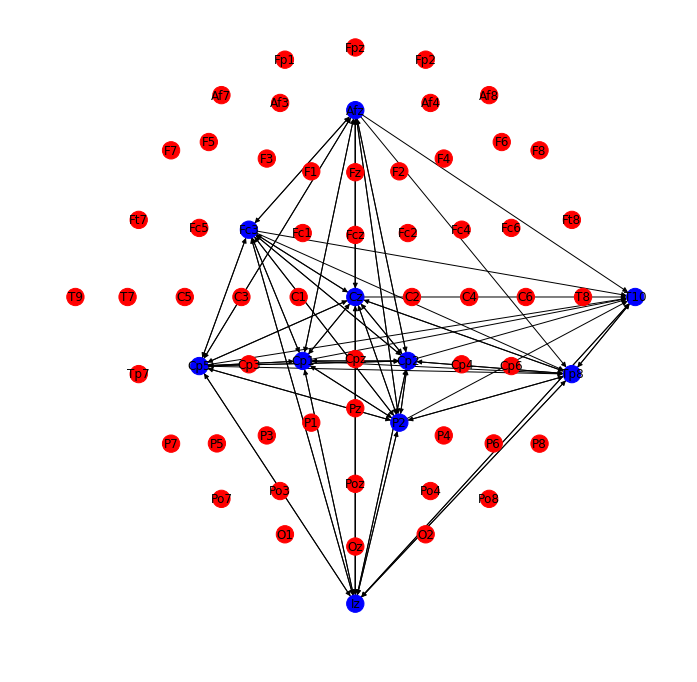

In [58]:
degree_est = estimation_1(sub_degree, 100)
T = find_T_est_1(degree_est,0.80)
adjj_degree= build_adj(degree_est, T)
gg_local_degree = build_graph_degree(adjj_degree,degree_channels,labels,chanel_locations)

# 3.1.
(mandatory) Perform motifs analysis to investigate the presence of 3-node configurations in
the networks: determine their frequency and statistical significance (motifs, anti-motifs).

In [59]:
#configs = ['A->B->C', 'A->B->C->A','A<-B->C','A->B<-C','A<-B->C->A','A->B<-C->A',\
 #         'A<-B->C<-A','A->B<-C<-A']

In [60]:
gg.nodes

NodeView(('Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz'))

In [61]:
gg.is_directed()

True

In [62]:
gg.in_edges('Fc5')

InEdgeDataView([('C5', 'Fc5')])

In [63]:
gg.out_edges('Fc5')

OutEdgeDataView([('Fc5', 'Fc3'), ('Fc5', 'C4'), ('Fc5', 'Cp5'), ('Fc5', 'Cp1'), ('Fc5', 'Afz'), ('Fc5', 'F3'), ('Fc5', 'F1'), ('Fc5', 'Fz'), ('Fc5', 'Ft7'), ('Fc5', 'T7'), ('Fc5', 'T9'), ('Fc5', 'T10'), ('Fc5', 'Tp8'), ('Fc5', 'P3'), ('Fc5', 'Pz'), ('Fc5', 'P8'), ('Fc5', 'Po3'), ('Fc5', 'Iz')])

In [64]:
set(gg.predecessors('Fc5'))

{'C5'}

In [65]:
set(gg.successors('Fc5'))

{'Afz',
 'C4',
 'Cp1',
 'Cp5',
 'F1',
 'F3',
 'Fc3',
 'Ft7',
 'Fz',
 'Iz',
 'P3',
 'P8',
 'Po3',
 'Pz',
 'T10',
 'T7',
 'T9',
 'Tp8'}

In [66]:
def get_freq(graph):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    #'A->B->C' #'A->B->C->A or A->B->C->B' # 'A->B->C->A->C' # A->B->C->A->C->B->A # A->B->C->B->A
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                if th!=node:
                    conf1.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    conf_6.add(tuple(sorted(set([node,sec,th,fourth,fi])) ))#(())
                        if fourth == node :
                            conf2.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    conf222.add(tuple(sorted(set([node,sec,th,fourth,fif]))))                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        conf_4.add(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    conf_5.add(tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                    if fourth==sec:
                        conf22.add(tuple(sorted(set([node,sec,th,fourth]))))
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    #pics.extend([conf1.pop(),conf2.pop(),conf22.pop(),conf222.pop(),conf_4.pop(),conf_5.pop()])
        #'A->B<-C' #'A->B<-C->A' or 'A->B<-C->A->C'
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf3.add(tuple(sorted(set([node,sec,th])) ))  
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            conf4.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    conf44.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    #pics.extend([conf3.pop(),conf4.pop(),conf44.pop()])
    # 'A<-B->C'  #'A<-B->C->B->A or A<-B->C->B'  # 'A<-B->C->A->C' 
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    conf5.add(tuple(sorted(set([node,sec,th])) ))
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    conf8.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
                        if fourth==sec:
                            conf7.add(tuple(sorted(set([node,sec,th,fourth]))))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    conf6.add(tuple(sorted(set([node,sec,th,fourth,fif]))))
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    #pics.extend([conf5.pop(),conf6.pop(),conf7.pop(),conf8.pop()])
    #'A<-B->A->C->A->C''A<-B->A->C->A->C->B'
    #poss_confs['A<-B->A->C->A->C']=len(conf9)
    #poss_confs['A<-B->A->C->A->C->B']=len(conf10)
    return poss_confs#,pics

In [67]:
res= get_freq(gg)

In [68]:
res

{'A->B->C': [6536],
 'A->B->C->A': [376],
 'A->B->C->B': [261],
 'A->B->C->A->C': [371],
 'A->B->C->A->C->B': [3883],
 'A->B->C->A->C->B->A': [58],
 'A->B->C->B->A': [355],
 'A->B<-C': [11879],
 'A->B<-C->A': [3660],
 'A->B<-C->A->C': [516],
 'A<-B->C': [4812],
 'A<-B->C->B': [900],
 'A<-B->C->A->C': [1040]}

In [69]:
64*63*62/6

41664.0

64!/(3!*61!) = 62*63*64/(6)

In [70]:
#sub_grs
#G.subgraph([0, 1, 2])
#nx.draw_networkx(k)
def sub_graphs(results_dict):
    results=[x for x in results_dict.keys() if results_dict[x][0]>0]
    number_of_colors = 15
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
    for i in range(len(results)):
        config = results[i]
        sub_graph = nx.DiGraph()
        sub_graph.add_nodes_from(['A','B','C'])
        for c  in range(len(config)):
            if config[c]=='>':
                sub_graph.add_edge(config[c-2],config[c+1])
            if config[c]=='<':
                sub_graph.add_edge(config[c+2],config[c-1])
        plt.figure(1,figsize=(2,2)) 
        nx.draw_networkx(sub_graph,node_color=random.choice(color),edge_color='b')
        plt.show()
        print(results_dict[config])


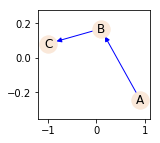

[6536]


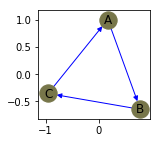

[376]


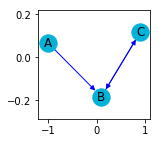

[261]


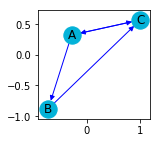

[371]


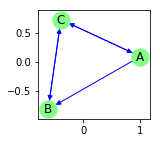

[3883]


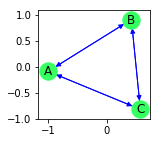

[58]


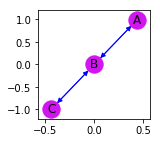

[355]


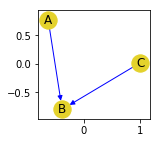

[11879]


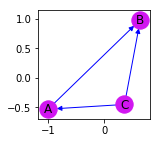

[3660]


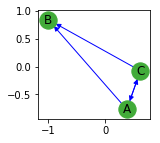

[516]


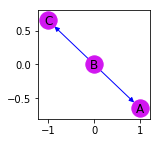

[4812]


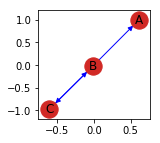

[900]


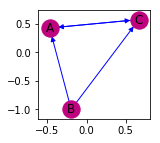

[1040]


In [71]:
sub_graphs(res)

In [72]:
def rand_freq(dens):
    e =nx.erdos_renyi_graph(64,dens,directed=True)
    freq = get_freq(e)
    for i in range(100):
        e =nx.erdos_renyi_graph(64,dens,directed=True)
        first = get_freq(e)
        for x in first.keys():
            freq[x].append(first[x][0])
    freqmean_std=freq
    for f in freq.keys():
        freqmean_std[f]=(np.mean(freq[f]),np.std(freq[f]))
    return freqmean_std

In [73]:
r_g = rand_freq(0.2)
res= get_freq(gg)

In [74]:
res

{'A->B->C': [6536],
 'A->B->C->A': [376],
 'A->B->C->B': [261],
 'A->B->C->A->C': [371],
 'A->B->C->A->C->B': [3883],
 'A->B->C->A->C->B->A': [58],
 'A->B->C->B->A': [355],
 'A->B<-C': [11879],
 'A->B<-C->A': [3660],
 'A->B<-C->A->C': [516],
 'A<-B->C': [4812],
 'A<-B->C->B': [900],
 'A<-B->C->A->C': [1040]}

In [75]:
def get_z(real, rand_g):
    result = {k: v for k, v in real.items()}
    for x in result.keys():
        div = (rand_g[x][1]+0.001)
        result[x]=(real[x][0]-rand_g[x][0])/(div)
    return result

In [76]:
get_z(res,r_g)

{'A->B->C': -3.5242347939548906,
 'A->B->C->A': -4.057899610554729,
 'A->B->C->B': 3.055260436844967,
 'A->B->C->A->C': 0.9622161701452467,
 'A->B->C->A->C->B': -0.6261278343864517,
 'A->B->C->A->C->B->A': 31.35593989915065,
 'A->B->C->B->A': 3.6821765770420805,
 'A->B<-C': 23.459827734369874,
 'A->B<-C->A': 13.682638892026455,
 'A->B<-C->A->C': 9.462723138632,
 'A<-B->C': 0.01345627885413063,
 'A<-B->C->B': -3.6496808341456233,
 'A<-B->C->A->C': 25.8886291692357}

In [77]:
r_g

{'A->B->C': (8225.910891089108, 479.5104372027106),
 'A->B->C->A': (667.0297029702971, 71.71829591686283),
 'A->B->C->B': (146.24752475247524, 37.557983143847665),
 'A->B->C->A->C': (323.56435643564356, 49.29732301321232),
 'A->B->C->A->C->B': (4381.6435643564355, 796.39158466294),
 'A->B->C->A->C->B->A': (2.742574257425743, 1.761263415489932),
 'A->B->C->B->A': (192.0, 44.26629587502268),
 'A->B<-C': (4796.8712871287125, 301.88223601778196),
 'A->B<-C->A': (1607.4554455445545, 150.00986929594873),
 'A->B<-C->A->C': (195.8019801980198, 33.83683030645345),
 'A<-B->C': (4808.039603960396, 294.3148418858597),
 'A<-B->C->B': (1597.039603960396, 190.98545488094317),
 'A<-B->C->A->C': (193.55445544554456, 32.694649469162094)}

In [78]:
final_counts = pd.DataFrame(res).T
final_counts['1']=list(get_z(res,r_g).values())
final_counts.columns = ['N_real','Z']

In [79]:
final_counts.shape

(13, 2)

In [80]:
final_counts

,N_real,Z
A->B->C,6536,-3.524235
A->B->C->A,376,-4.057900
A->B->C->B,261,3.055260
A->B->C->A->C,371,0.962216
A->B->C->A->C->B,3883,-0.626128
A->B->C->A->C->B->A,58,31.355940
A->B->C->B->A,355,3.682177
A->B<-C,11879,23.459828
A->B<-C->A,3660,13.682639
A->B<-C->A->C,516,9.462723


# 3.2
(class ‘C’) For the motif with pattern A → B ← C, create a topographical representation of the
networks considering only the connections involved in this configuration.

In [81]:
def func_3_2(graph):
    set_of_3 = set()
       
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                #set_of_3.add((node,sec,th))
                if th!=node:
                    set_of_3.add((node,sec))
                    set_of_3.add((th,sec))
                
    return set_of_3

In [82]:
edges = func_3_2(gg)

In [83]:
def build_graph_3_2(edges,labels,coord):
    #idx_i, inx_j = np.where(adj==1)
    #idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = list(edges)#[(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

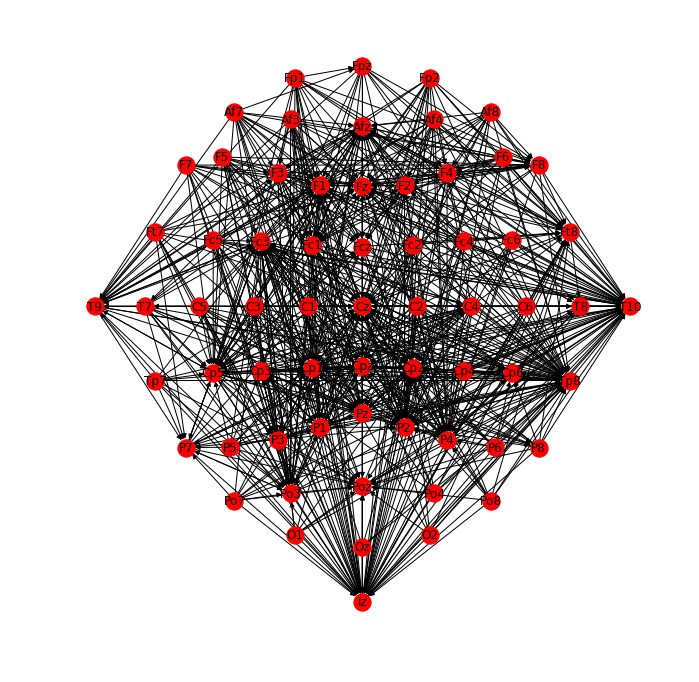

In [84]:
build_graph_3_2(edges,labels,chanel_locations)

In [85]:
len(edges)

809

In [86]:
len(gg.edges())

818

# 3.3
(class ‘C’) Choose a channel selected in parieto-occipital scalp region and determine the
motifs which involve it.

In [87]:
labels.index('Po8')

59

In [88]:
def get_freq_po(graph,po):
    #pics=[]
    configs = ['A->B->C', 'A->B->C->A','A->B<-C','A->B<-C->A','A<-B->C', 'A<-B->C->A']
    #'A->B->C' #'A->B->C->A or A->B->C->B' # 'A->B->C->A->C' # A->B->C->A->C->B->A # A->B->C->B->A
    conf1,conf2,conf22,conf222,conf_4,conf_5,conf_6 = set(),set(),set(),set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            for th in third_step:
                t = (tuple(sorted(set([node,sec,th]))))
                if (po in t) and th!=node:
                    conf1.add(t)
                if node!=th:
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == sec:
                            fifth = set(graph.successors(fourth))
                            for fi in fifth:
                                if node==fi:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fi]))))
                                    if po in t:conf_6.add(t)
                        if fourth == node :
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t: conf2.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:

                                if fif==th:
                                    t= (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf222.add(t)                            
                                    six = set(graph.successors(fif))
                                    for s in six:
                                        t=(tuple(sorted(set([node,sec,th,fourth,fif,s]))))
                                        if po in t:
                                            conf_4.add(t)
                                        if s==sec:
                                            sev = set(graph.successors(s))
                                            for se in sev:
                                                if se==node:
                                                    t= (tuple(sorted(set([node,sec,th,fourth,fif,s,se]))))
                                                    if po in t:
                                                        conf_5.add(t)
                        if fourth==sec:
                            t= (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf22.add(t)
    poss_confs={configs[0] : [len(conf1)]}
    poss_confs[configs[1]]=[len(conf2)]
    poss_confs['A->B->C->B']=[len(conf22)]
    poss_confs['A->B->C->A->C']=[len(conf222)]
    poss_confs['A->B->C->A->C->B']=[len(conf_4)]
    poss_confs['A->B->C->A->C->B->A']=[len(conf_5)]
    poss_confs['A->B->C->B->A']=[len(conf_6)]
    #pics.extend([conf1.pop(),conf2.pop(),conf22.pop(),conf222.pop(),conf_4.pop(),conf_5.pop()])
        #'A->B<-C' #'A->B<-C->A' or 'A->B<-C->A->C'
    conf3, conf4, conf44 = set(),set(),set()      
    for node in graph.nodes:
        second_step = set(graph.successors(node))
        for sec in second_step:
            third_step = set(graph.predecessors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf3.add(t)    
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node:
                            t=(tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf4.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif==th:
                                    t=(tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf44.add(t)
    poss_confs[configs[2]]=[len(conf3)]
    poss_confs[configs[3]]=[len(conf4)]
    poss_confs['A->B<-C->A->C']=[len(conf44)]
    #pics.extend([conf3.pop(),conf4.pop(),conf44.pop()])
    # 'A<-B->C'  #'A<-B->C->B->A or A<-B->C->B'  # 'A<-B->C->A->C' 
    conf5,conf6,conf7,conf8 = set(),set(),set(),set()
    for node in graph.nodes:
        second_step = set(graph.predecessors(node))
        for sec in second_step:
            third_step = set(graph.successors(sec))
            #print(third_step)
            for th in third_step:
                if th!=node:
                    t = (tuple(sorted(set([node,sec,th]))))
                    if po in t:
                        conf5.add(t)
                    fourth_step = set(graph.successors(th))
                    for fourth in fourth_step:
                        if fourth == node and th!=node:
                            #conf6.add((node,sec,th,fourth))
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == th:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf8.add(t)
                        if fourth==sec and th!=node:
                            t = (tuple(sorted(set([node,sec,th,fourth]))))
                            if po in t:
                                conf7.add(t)
                            fifth = set(graph.successors(fourth))
                            for fif in fifth:
                                if fif == node:
                                    t = (tuple(sorted(set([node,sec,th,fourth,fif]))))
                                    if po in t:
                                        conf6.add(t)
    poss_confs[configs[4]]=[len(conf5)]
    #poss_confs['A<-B->C->B->A']=len(conf6)
    poss_confs['A<-B->C->B']=[len(conf7)]
    poss_confs['A<-B->C->A->C']=[len(conf8)]
    #pics.extend([conf5.pop(),conf6.pop(),conf7.pop(),conf8.pop()])
    #'A<-B->A->C->A->C''A<-B->A->C->A->C->B'
    #poss_confs['A<-B->A->C->A->C']=len(conf9)
    #poss_confs['A<-B->A->C->A->C->B']=len(conf10)
    return poss_confs#,pics

In [89]:
get_freq_po(gg,'Po8')

{'A->B->C': [87],
 'A->B->C->A': [0],
 'A->B->C->B': [43],
 'A->B->C->A->C': [0],
 'A->B->C->A->C->B': [0],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [0],
 'A->B<-C': [369],
 'A->B<-C->A': [45],
 'A->B<-C->A->C': [0],
 'A<-B->C': [55],
 'A<-B->C->B': [0],
 'A<-B->C->A->C': [11]}

In [90]:
gg.in_edges('Po8')

InEdgeDataView([])

In [91]:
set(gg.successors('Po8'))

{'Cp2', 'Cz', 'Fc3', 'Ft8', 'Fz', 'Iz', 'P4', 'Po4', 'Poz', 'T10', 'Tp8'}

In [92]:
cc=0
for s in set(gg.successors('Po8')):
    cc=cc+len(set(gg.predecessors(s)))
print(cc)

391


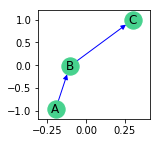

[87]


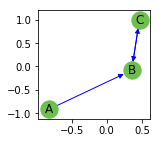

[43]


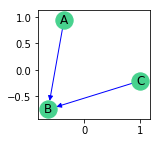

[369]


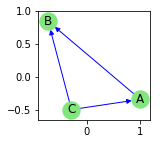

[45]


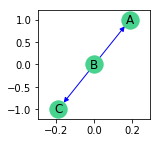

[55]


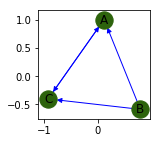

[11]


In [93]:
sub_graphs(get_freq_po(gg,'Po8'))

In [94]:
get_freq_po(gg,'Poz')

{'A->B->C': [371],
 'A->B->C->A': [14],
 'A->B->C->B': [77],
 'A->B->C->A->C': [14],
 'A->B->C->A->C->B': [312],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [6],
 'A->B<-C': [456],
 'A->B<-C->A': [163],
 'A->B<-C->A->C': [18],
 'A<-B->C': [233],
 'A<-B->C->B': [52],
 'A<-B->C->A->C': [26]}

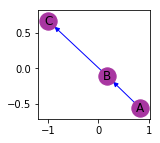

[371]


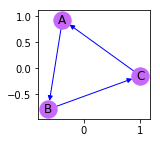

[14]


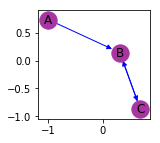

[77]


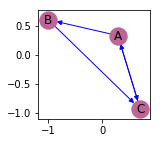

[14]


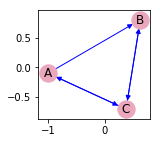

[312]


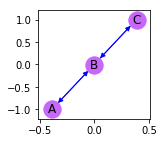

[6]


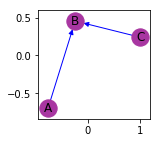

[456]


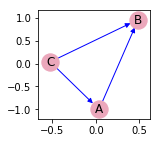

[163]


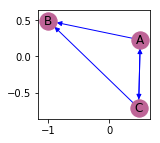

[18]


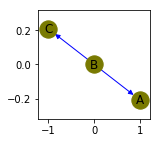

[233]


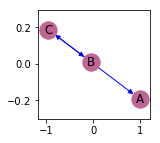

[52]


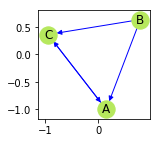

[26]


In [95]:
sub_graphs(get_freq_po(gg,'Poz'))

In [96]:
get_freq_po(gg,'Po7')

{'A->B->C': [103],
 'A->B->C->A': [0],
 'A->B->C->B': [46],
 'A->B->C->A->C': [0],
 'A->B->C->A->C->B': [0],
 'A->B->C->A->C->B->A': [0],
 'A->B->C->B->A': [0],
 'A->B<-C': [351],
 'A->B<-C->A': [46],
 'A->B<-C->A->C': [0],
 'A<-B->C': [55],
 'A<-B->C->B': [0],
 'A<-B->C->A->C': [12]}

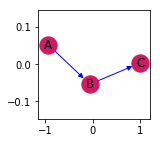

[103]


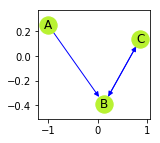

[46]


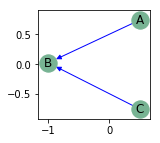

[351]


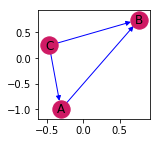

[46]


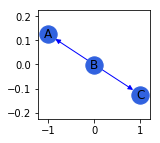

[55]


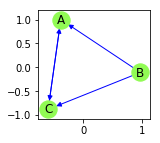

[12]


In [97]:
sub_graphs(get_freq_po(gg,'Po7'))